In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


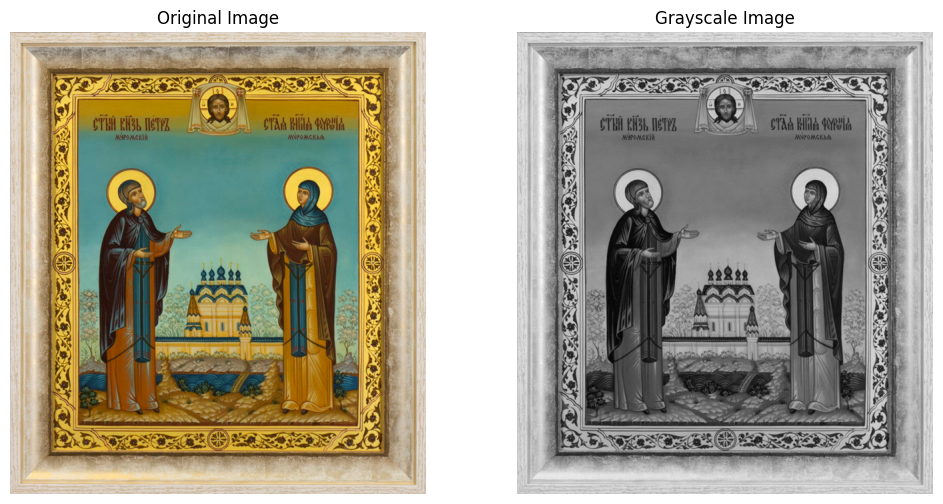

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def load_image_as_tensor(image_path):
    """Load an image and convert it to a PyTorch tensor."""
    image = Image.open(image_path)
    transform = transforms.ToTensor()
    return transform(image)

def show_images(original_tensor, grayscale_tensor):
    """Display the original and grayscale images side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_tensor.permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(grayscale_tensor.squeeze(), cmap='gray')
    ax[1].set_title("Grayscale Image")
    ax[1].axis('off')

    plt.show()

def process_directory(directory_path, output_directory_base):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.png'):
                original_image_path = os.path.join(root, file)

                # Assuming grayscale images are saved in a mirrored directory structure
                relative_path = os.path.relpath(root, directory_path)
                grayscale_image_path = os.path.join(output_directory_base, relative_path, file)

                if os.path.exists(grayscale_image_path):  # Check if the grayscale image exists
                    # Load images as PyTorch tensors
                    original_tensor = load_image_as_tensor(original_image_path)
                    grayscale_tensor = load_image_as_tensor(grayscale_image_path)

                    # Show the images
                    show_images(original_tensor, grayscale_tensor)

                return  # Process only one image per directory

# Define the paths
directory_path = r'/content/drive/MyDrive/dataset/training_set'  # Update this path
output_directory_base = r'/content/drive/MyDrive/dataset/gray_training_set'  # Update this path

# Process one image from each directory
process_directory(directory_path, output_directory_base)

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform_grayscale=None, transform_color=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform_grayscale: Transforms for grayscale images.
        transform_color: Transforms for color images.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform_grayscale)
        self.color_dataset = ImageFolder(color_dir, transform=transform_color)

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Transform for grayscale images (input)
transform_grayscale = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transform for color images (target)
transform_color = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

training_data = GrayscaleColorizationDataset(
    grayscale_dir=r'/content/drive/MyDrive/dataset/gray_training_set',
    color_dir=r'/content/drive/MyDrive/dataset/training_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

validation_data = GrayscaleColorizationDataset(
    grayscale_dir=r'/content/drive/MyDrive/dataset/gray_validation_set',
    color_dir=r'/content/drive/MyDrive/dataset/validation_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

training_loader = DataLoader(training_data, num_workers=0, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=0, batch_size=16, shuffle=True)



In [ ]:
import torch
from torch import nn

class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)
        # Additional upsampling to correct size
        self.upsample_layers = nn.Sequential(
           nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
        )

        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.final_activation = nn.Tanh()

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        x = self.upsample_layers(conv8_3)
        final_out = self.final_conv(x)
        out_tanh = self.final_activation(final_out)
        # Adjust from [-1, 1] to [0, 1] if still needed
        out_adjusted = (out_tanh + 1) / 2
        return out_adjusted

In [ ]:
import torchvision
class PerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(PerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False

        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406], device='cuda').view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225], device='cuda').view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += torch.nn.functional.l1_loss(x, y)
        return loss

In [ ]:
import torch.nn.functional as F

class CombinedLoss(torch.nn.Module):
    def __init__(self, perceptual_loss):
        super(CombinedLoss, self).__init__()
        self.perceptual_loss = perceptual_loss
        self.smooth_l1_loss = torch.nn.SmoothL1Loss()
        self.mse_loss = torch.nn.MSELoss()
        self.beta = 0.25
        self.gamma = 0.25

    def forward(self, outputs, targets):
        perc_loss = self.perceptual_loss(outputs, targets)
        l1_loss = self.smooth_l1_loss(outputs, targets)
        mse_loss = self.mse_loss(outputs, targets)
        total_loss = perc_loss + self.beta * l1_loss + self.gamma * mse_loss
        return total_loss

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

model = ECCVGenerator().cuda()  # Initialize your model
initial_lr = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

num_epochs = 80

scheduler = OneCycleLR(optimizer, max_lr = 0.0001, epochs=num_epochs, steps_per_epoch=len(training_loader))
training_losses = []
validation_losses = []

perceptual_loss = PerceptualLoss().cuda()

criterion = CombinedLoss(perceptual_loss).cuda()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_loader = tqdm(training_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')

    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        train_loader.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(training_loader)
    training_losses.append(avg_train_loss)
    print(f'\nEpoch {epoch+1}, Training Loss: {avg_train_loss:.4f}')

    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    validation_loader_tqdm = tqdm(validation_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
    with torch.no_grad():
        for inputs, targets in validation_loader_tqdm:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            validation_loss += loss.item()
            validation_loader_tqdm.set_postfix(loss=loss.item())

    avg_validation_loss = validation_loss / len(validation_loader)
    validation_losses.append(avg_validation_loss)
    print(f'\nEpoch {epoch+1}, Validation Loss: {avg_validation_loss:.4f}')

Epoch 1/80 [Training]:  57%|█████▋    | 276/483 [1:04:27<43:39, 12.65s/it, loss=2.68]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/80 [Training]: 100%|██████████| 483/483 [1:51:04<00:00, 13.80s/it, loss=2.83]



Epoch 1, Training Loss: 2.5957


Epoch 1/80 [Validation]: 100%|██████████| 54/54 [10:54<00:00, 12.11s/it, loss=1.92]



Epoch 1, Validation Loss: 2.5514


Epoch 2/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=2.73]



Epoch 2, Training Loss: 2.5770


Epoch 2/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=2.69]



Epoch 2, Validation Loss: 2.5605


Epoch 3/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=2.94]



Epoch 3, Training Loss: 2.5714


Epoch 3/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.55it/s, loss=2.63]



Epoch 3, Validation Loss: 2.5604


Epoch 4/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=2.49]



Epoch 4, Training Loss: 2.5665


Epoch 4/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s, loss=2.53]



Epoch 4, Validation Loss: 2.5500


Epoch 5/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=2.89]



Epoch 5, Training Loss: 2.5620


Epoch 5/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=2.54]



Epoch 5, Validation Loss: 2.5474


Epoch 6/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=2.46]



Epoch 6, Training Loss: 2.5548


Epoch 6/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.57it/s, loss=2.71]



Epoch 6, Validation Loss: 2.5916


Epoch 7/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=2.69]



Epoch 7, Training Loss: 2.5422


Epoch 7/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s, loss=2.44]



Epoch 7, Validation Loss: 2.5550


Epoch 8/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=2.67]



Epoch 8, Training Loss: 2.5180


Epoch 8/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.63it/s, loss=3.3]



Epoch 8, Validation Loss: 3.0854


Epoch 9/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=2.41]



Epoch 9, Training Loss: 2.3401


Epoch 9/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s, loss=3.15]



Epoch 9, Validation Loss: 2.6709


Epoch 10/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=2.24]



Epoch 10, Training Loss: 2.1635


Epoch 10/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.57it/s, loss=2.42]



Epoch 10, Validation Loss: 2.5856


Epoch 11/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=1.78]



Epoch 11, Training Loss: 2.0169


Epoch 11/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.62it/s, loss=2.87]



Epoch 11, Validation Loss: 2.9816


Epoch 12/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.74]



Epoch 12, Training Loss: 1.9070


Epoch 12/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=4.77]



Epoch 12, Validation Loss: 4.5182


Epoch 13/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.77]



Epoch 13, Training Loss: 1.8280


Epoch 13/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=2.73]



Epoch 13, Validation Loss: 2.7850


Epoch 14/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.79]



Epoch 14, Training Loss: 1.7744


Epoch 14/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=3.24]



Epoch 14, Validation Loss: 2.9760


Epoch 15/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.89]



Epoch 15, Training Loss: 1.7204


Epoch 15/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.62it/s, loss=3.44]



Epoch 15, Validation Loss: 3.0535


Epoch 16/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.75]



Epoch 16, Training Loss: 1.6772


Epoch 16/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=2.3]



Epoch 16, Validation Loss: 2.4650


Epoch 17/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.71]



Epoch 17, Training Loss: 1.6430


Epoch 17/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.66it/s, loss=3.26]



Epoch 17, Validation Loss: 3.0556


Epoch 18/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.67]



Epoch 18, Training Loss: 1.6047


Epoch 18/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.57it/s, loss=2.8]



Epoch 18, Validation Loss: 3.0151


Epoch 19/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.94]



Epoch 19, Training Loss: 1.5742


Epoch 19/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=2.32]



Epoch 19, Validation Loss: 2.4231


Epoch 20/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.6]



Epoch 20, Training Loss: 1.5460


Epoch 20/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=2.96]



Epoch 20, Validation Loss: 3.0495


Epoch 21/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.3]



Epoch 21, Training Loss: 1.5216


Epoch 21/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.61it/s, loss=3.15]



Epoch 21, Validation Loss: 2.9408


Epoch 22/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.2]



Epoch 22, Training Loss: 1.5058


Epoch 22/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.53it/s, loss=2.59]



Epoch 22, Validation Loss: 2.6665


Epoch 23/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.67]



Epoch 23, Training Loss: 1.4848


Epoch 23/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.57it/s, loss=2.37]



Epoch 23, Validation Loss: 2.3631


Epoch 24/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.42]



Epoch 24, Training Loss: 1.4699


Epoch 24/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.61it/s, loss=2.76]



Epoch 24, Validation Loss: 2.6162


Epoch 25/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.54]



Epoch 25, Training Loss: 1.4501


Epoch 25/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.57it/s, loss=2.57]



Epoch 25, Validation Loss: 2.5190


Epoch 26/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.27]



Epoch 26, Training Loss: 1.4330


Epoch 26/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.63it/s, loss=2.29]



Epoch 26, Validation Loss: 2.5244


Epoch 27/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.4]



Epoch 27, Training Loss: 1.4177


Epoch 27/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.61it/s, loss=2.6]



Epoch 27, Validation Loss: 2.9369


Epoch 28/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=1.01]



Epoch 28, Training Loss: 1.4022


Epoch 28/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=2.58]



Epoch 28, Validation Loss: 2.5054


Epoch 29/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.53]



Epoch 29, Training Loss: 1.3920


Epoch 29/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.61it/s, loss=2.2]



Epoch 29, Validation Loss: 2.5420


Epoch 30/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.3]



Epoch 30, Training Loss: 1.3792


Epoch 30/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.61it/s, loss=2.66]



Epoch 30, Validation Loss: 2.5281


Epoch 31/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.4]



Epoch 31, Training Loss: 1.3656


Epoch 31/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.56it/s, loss=2.84]



Epoch 31, Validation Loss: 2.9205


Epoch 32/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.67]



Epoch 32, Training Loss: 1.3560


Epoch 32/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.66it/s, loss=2.79]



Epoch 32, Validation Loss: 2.8311


Epoch 33/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.3]



Epoch 33, Training Loss: 1.3408


Epoch 33/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s, loss=2.45]



Epoch 33, Validation Loss: 2.5635


Epoch 34/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.43]



Epoch 34, Training Loss: 1.3295


Epoch 34/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s, loss=2.34]



Epoch 34, Validation Loss: 2.4150


Epoch 35/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.23]



Epoch 35, Training Loss: 1.3197


Epoch 35/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.61it/s, loss=3.03]



Epoch 35, Validation Loss: 2.7405


Epoch 36/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.42]



Epoch 36, Training Loss: 1.3077


Epoch 36/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=2.72]



Epoch 36, Validation Loss: 2.5144


Epoch 37/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=0.945]



Epoch 37, Training Loss: 1.2933


Epoch 37/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=3.08]



Epoch 37, Validation Loss: 2.9162


Epoch 38/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.18]



Epoch 38, Training Loss: 1.2855


Epoch 38/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=4.06]



Epoch 38, Validation Loss: 3.9912


Epoch 39/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.39]



Epoch 39, Training Loss: 1.2741


Epoch 39/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=3.12]



Epoch 39, Validation Loss: 3.2170


Epoch 40/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.15]



Epoch 40, Training Loss: 1.2664


Epoch 40/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.62it/s, loss=3.19]



Epoch 40, Validation Loss: 2.9882


Epoch 41/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.21]



Epoch 41, Training Loss: 1.2601


Epoch 41/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.61it/s, loss=2.75]



Epoch 41, Validation Loss: 2.5998


Epoch 42/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=1.16]



Epoch 42, Training Loss: 1.2476


Epoch 42/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.57it/s, loss=2.26]



Epoch 42, Validation Loss: 2.3937


Epoch 43/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.22]



Epoch 43, Training Loss: 1.2369


Epoch 43/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=2.53]



Epoch 43, Validation Loss: 2.3995


Epoch 44/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.1]



Epoch 44, Training Loss: 1.2280


Epoch 44/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=2.13]



Epoch 44, Validation Loss: 2.1604


Epoch 45/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.25]



Epoch 45, Training Loss: 1.2190


Epoch 45/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=2.34]



Epoch 45, Validation Loss: 2.6938


Epoch 46/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.35]



Epoch 46, Training Loss: 1.2098


Epoch 46/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.66it/s, loss=2.23]



Epoch 46, Validation Loss: 2.4606


Epoch 47/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.28]



Epoch 47, Training Loss: 1.2014


Epoch 47/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=1.98]



Epoch 47, Validation Loss: 2.2840


Epoch 48/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.59]



Epoch 48, Training Loss: 1.1921


Epoch 48/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.55it/s, loss=2.19]



Epoch 48, Validation Loss: 2.2157


Epoch 49/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.09]



Epoch 49, Training Loss: 1.1833


Epoch 49/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.62it/s, loss=2.21]



Epoch 49, Validation Loss: 2.2365


Epoch 50/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.23]



Epoch 50, Training Loss: 1.1728


Epoch 50/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=3.07]



Epoch 50, Validation Loss: 3.0705


Epoch 51/80 [Training]: 100%|██████████| 483/483 [02:24<00:00,  3.35it/s, loss=1.04]



Epoch 51, Training Loss: 1.1663


Epoch 51/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.62it/s, loss=2.58]



Epoch 51, Validation Loss: 2.5671


Epoch 52/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.36it/s, loss=1.24]



Epoch 52, Training Loss: 1.1562


Epoch 52/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.62it/s, loss=2.37]



Epoch 52, Validation Loss: 2.4242


Epoch 53/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.35it/s, loss=1.15]



Epoch 53, Training Loss: 1.1486


Epoch 53/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.57it/s, loss=2.15]



Epoch 53, Validation Loss: 2.3216


Epoch 54/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.38it/s, loss=0.698]



Epoch 54, Training Loss: 1.1421


Epoch 54/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.57it/s, loss=2.29]



Epoch 54, Validation Loss: 2.1660


Epoch 55/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.39it/s, loss=1.42]



Epoch 55, Training Loss: 1.1337


Epoch 55/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.66it/s, loss=2.05]



Epoch 55, Validation Loss: 2.2825


Epoch 56/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=1.06]



Epoch 56, Training Loss: 1.1256


Epoch 56/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.63it/s, loss=2.26]



Epoch 56, Validation Loss: 2.3738


Epoch 57/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=0.883]



Epoch 57, Training Loss: 1.1172


Epoch 57/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.66it/s, loss=2.71]



Epoch 57, Validation Loss: 2.5004


Epoch 58/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=1.04]



Epoch 58, Training Loss: 1.1112


Epoch 58/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.65it/s, loss=2.49]



Epoch 58, Validation Loss: 2.4539


Epoch 59/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.38it/s, loss=1.55]



Epoch 59, Training Loss: 1.1028


Epoch 59/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.63it/s, loss=2.86]



Epoch 59, Validation Loss: 2.6918


Epoch 60/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=1.18]



Epoch 60, Training Loss: 1.0954


Epoch 60/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=1.87]



Epoch 60, Validation Loss: 1.9336


Epoch 61/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=1.4]



Epoch 61, Training Loss: 1.0909


Epoch 61/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s, loss=2.65]



Epoch 61, Validation Loss: 2.5475


Epoch 62/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.39it/s, loss=1.26]



Epoch 62, Training Loss: 1.0837


Epoch 62/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.62it/s, loss=2.48]



Epoch 62, Validation Loss: 2.3574


Epoch 63/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=1.15]



Epoch 63, Training Loss: 1.0793


Epoch 63/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.64it/s, loss=1.43]



Epoch 63, Validation Loss: 1.4636


Epoch 64/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.39it/s, loss=1.25]



Epoch 64, Training Loss: 1.0734


Epoch 64/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.65it/s, loss=2.45]



Epoch 64, Validation Loss: 2.5803


Epoch 65/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.38it/s, loss=1.26]



Epoch 65, Training Loss: 1.0671


Epoch 65/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.66it/s, loss=2.3]



Epoch 65, Validation Loss: 2.1643


Epoch 66/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=1.08]



Epoch 66, Training Loss: 1.0612


Epoch 66/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.68it/s, loss=1.65]



Epoch 66, Validation Loss: 1.5142


Epoch 67/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=0.804]



Epoch 67, Training Loss: 1.0588


Epoch 67/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.64it/s, loss=2.01]



Epoch 67, Validation Loss: 1.5028


Epoch 68/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.39it/s, loss=1]



Epoch 68, Training Loss: 1.0532


Epoch 68/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.62it/s, loss=2.07]



Epoch 68, Validation Loss: 2.0334


Epoch 69/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=0.973]



Epoch 69, Training Loss: 1.0500


Epoch 69/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=1.06]



Epoch 69, Validation Loss: 1.3949


Epoch 70/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=1.01]



Epoch 70, Training Loss: 1.0465


Epoch 70/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.66it/s, loss=1.61]



Epoch 70, Validation Loss: 1.5267


Epoch 71/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=1.16]



Epoch 71, Training Loss: 1.0439


Epoch 71/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=1.11]



Epoch 71, Validation Loss: 1.2915


Epoch 72/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=1.01]



Epoch 72, Training Loss: 1.0400


Epoch 72/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.59it/s, loss=1.14]



Epoch 72, Validation Loss: 1.2956


Epoch 73/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=1.16]



Epoch 73, Training Loss: 1.0379


Epoch 73/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.65it/s, loss=1.56]



Epoch 73, Validation Loss: 1.3414


Epoch 74/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=0.94]



Epoch 74, Training Loss: 1.0353


Epoch 74/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.58it/s, loss=1.24]



Epoch 74, Validation Loss: 1.3179


Epoch 75/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=1.1]



Epoch 75, Training Loss: 1.0337


Epoch 75/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.55it/s, loss=1.01]



Epoch 75, Validation Loss: 1.2836


Epoch 76/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.39it/s, loss=1.18]



Epoch 76, Training Loss: 1.0331


Epoch 76/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=1.34]



Epoch 76, Validation Loss: 1.2691


Epoch 77/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=1.13]



Epoch 77, Training Loss: 1.0323


Epoch 77/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.64it/s, loss=1.62]



Epoch 77, Validation Loss: 1.2788


Epoch 78/80 [Training]: 100%|██████████| 483/483 [02:22<00:00,  3.38it/s, loss=0.864]



Epoch 78, Training Loss: 1.0305


Epoch 78/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.60it/s, loss=1.71]



Epoch 78, Validation Loss: 1.2680


Epoch 79/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=0.612]



Epoch 79, Training Loss: 1.0302


Epoch 79/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.64it/s, loss=1.49]



Epoch 79, Validation Loss: 1.2669


Epoch 80/80 [Training]: 100%|██████████| 483/483 [02:23<00:00,  3.37it/s, loss=1.06]



Epoch 80, Training Loss: 1.0310


Epoch 80/80 [Validation]: 100%|██████████| 54/54 [00:11<00:00,  4.64it/s, loss=1.18]


Epoch 80, Validation Loss: 1.2608


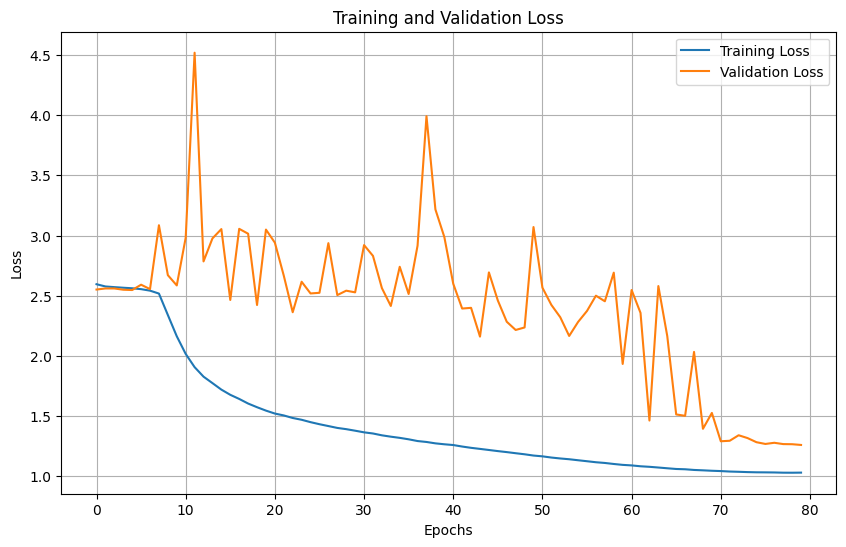

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

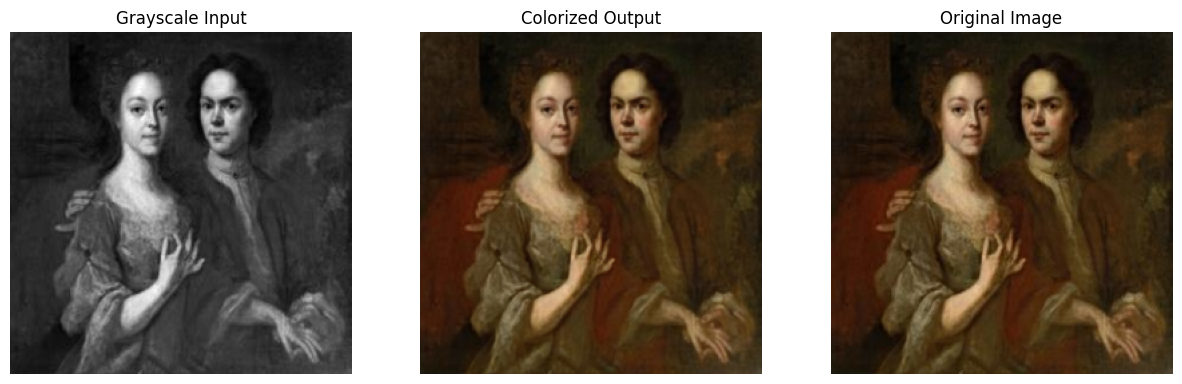

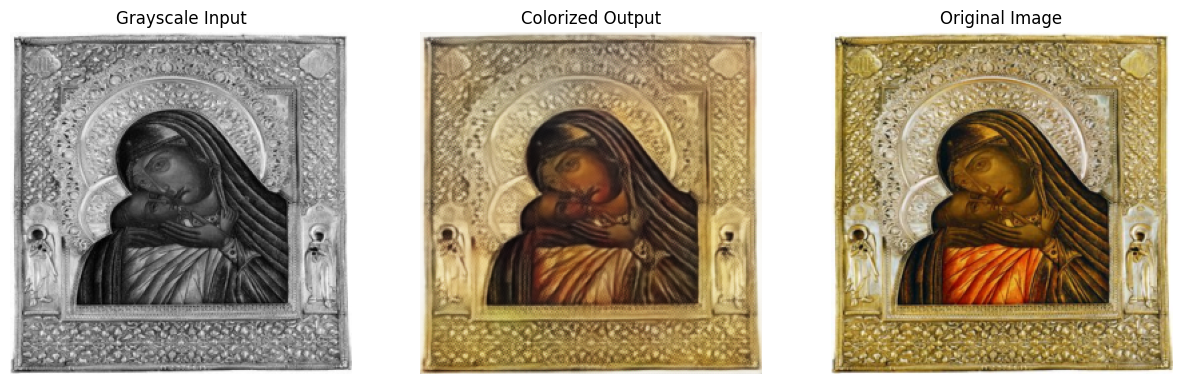

In [ ]:
def visualize_results(grayscale, colorized, original):
    """
    Visualize grayscale input, colorized output, and the original color image.
    """
    with torch.no_grad():
        # Convert to numpy arrays
        grayscale = grayscale.cpu().numpy().transpose((1, 2, 0))
        colorized = colorized.cpu().numpy().transpose((1, 2, 0))
        original = original.cpu().numpy().transpose((1, 2, 0))

        # Plot
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(grayscale, cmap='gray')
        ax[0].set_title("Grayscale Input")
        ax[0].axis("off")

        ax[1].imshow(colorized)
        ax[1].set_title("Colorized Output")
        ax[1].axis("off")

        ax[2].imshow(original)
        ax[2].set_title("Original Image")
        ax[2].axis("off")

        plt.show()

# Assuming `model`, `validation_loader` are already defined and ready to use
model.eval()
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[1], colorized_outputs[1], original_colors[1])
    visualize_results(grayscale_inputs[10], colorized_outputs[10], original_colors[10])

In [ ]:
import torch
model_path = r'/content/drive/MyDrive/DS_301_Project_Group_1_Picture_Colorization/model/artifact/vgg-16_loss=MSESmoothPerceptualLoss_batch32_OneCycleLR/model_state_dict.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
import csv

# Specify the path to the CSV file where you want to save the losses
csv_file_path = model_path+'losses.csv'

# Open the file in write mode
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    # Write the headers
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])

    # Write the losses for each epoch
    for epoch in range(num_epochs):
        writer.writerow([epoch + 1, training_losses[epoch], validation_losses[epoch]])

print(f"Losses saved to {csv_file_path}")

Losses saved to /content/drive/MyDrive/DS_301_Project_Group_1_Picture_Colorization/model/artifact/vgg-16_loss=MSESmoothPerceptualLoss_batch32_OneCycleLR/model_state_dict.pthlosses.csv


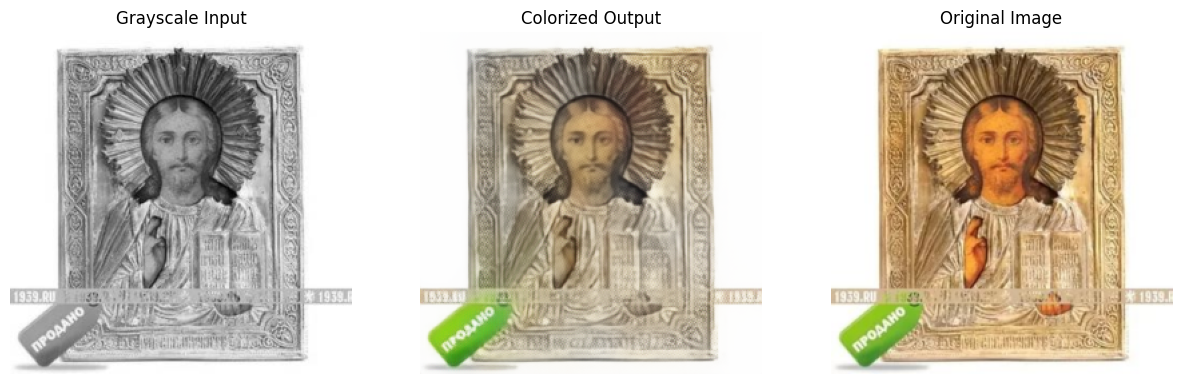

In [ ]:
model = ECCVGenerator().cuda()  # Or just ECCVGenerator() if not using CUDA

# Load the weights back
model.load_state_dict(torch.load(model_path))

# Don't forget to call model.eval() if you're in inference mode
model.eval()
with torch.no_grad():
    # Get a batch from the validation set
    grayscale_inputs, original_colors = next(iter(validation_loader))
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    # Generate colorized outputs
    colorized_outputs = model(grayscale_inputs)

    # Visualize the results for the first image in the batch
    visualize_results(grayscale_inputs[5], colorized_outputs[5], original_colors[5])